In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

# read csv file
# use "days since..." column for time
# have about 3 months with complete data for at least some variables
# basic FFT doesn't work with gaps!
# Date&TimeGMT, Days since 1/1/1900 00:00Z ,NITRATE[µM] ,WATERDEPTH[M] ,SALINITY ,TEMPERATURE[°C] ,
# SENSORDEPTH[M] ,OXYGEN[µM] ,CHLOROPHYLL[µG/L] ,TURBIDITY[NTU] ,CDOM[MG/M3] ,ALONGCHANNELVELOCITY[M/S] ,
# ACROSSCHANNELVELOCITY[M/S] ,PH_TOTAL_INSITUT ,PH_TOTAL_20C


filename = 'L01SURF_subset.txt'
data = np.genfromtxt(filename, delimiter=',', skip_header=3)

In [2]:
np.shape(data)

(1932, 15)

In [3]:
# Note values of 1.79E+308 as missing values.
# find big values
flagi = np.where(data>1E100)
data[flagi] = np.nan
# Warning issued must be ignored - relates to the huge values.

/home/steve/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
# Pull out water depth and analyze just that
time = data[:, 1]
waterdep = data[:, 3]

<IPython.core.display.Javascript object>


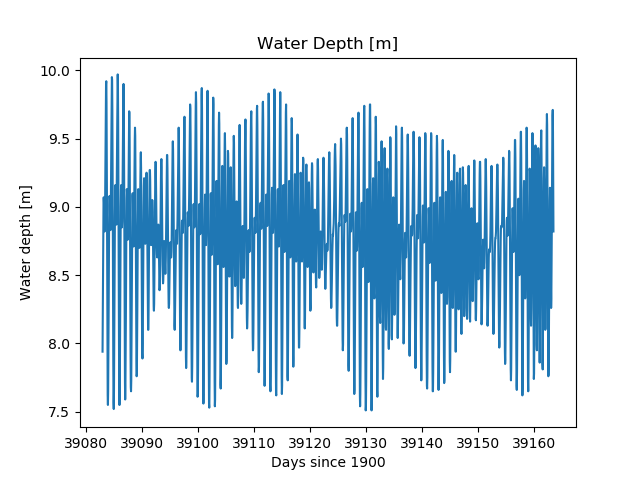

Text(0.5,1,'Water Depth [m]')

In [5]:
plt.figure()
plt.plot(time, waterdep)
plt.xlabel('Days since 1900')
plt.ylabel('Water depth [m]')
plt.title('Water Depth [m]')
# Note that data cover about 80 days.  Mean depth about 8.8 m.
# Range varies on a spring/neap cycle.

In [6]:
# Find a variable without bad values
print('Bad waterdep = ', sum(np.isnan(waterdep)))
turbidity = data[:, 9]
print('Bad turbidity = ', sum(np.isnan(turbidity)))
oxygen = data[:, 7]
print('Bad oxygen = ', sum(np.isnan(oxygen)))

Bad waterdep =  0
Bad turbidity =  547
Bad oxygen =  0


<IPython.core.display.Javascript object>


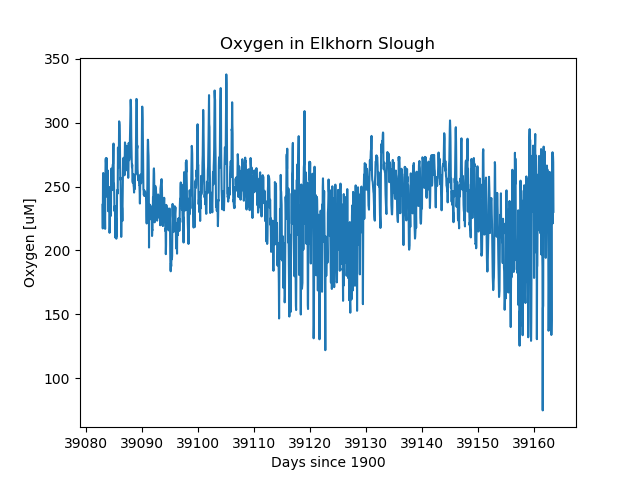

Text(0.5,1,'Oxygen in Elkhorn Slough')

In [7]:
plt.figure()
plt.plot(time, oxygen)
plt.xlabel('Days since 1900')
plt.ylabel('Oxygen [uM]')
plt.title('Oxygen in Elkhorn Slough')

In [8]:
# The fundamental frequency is the length of the data record.
f_fund = 1/(time[-1] - time[0])
# Nyquist is 1/(2dt)
dt = (time[-1] - time[0]) / (len(time)-1)
f_nyq = 1/(2.0*dt)
print('Fundamental freq =', f_fund, 'Nyquist freq = ', f_nyq,' in cycles per day')

Fundamental freq = 0.0124287938862 Nyquist freq =  12.0000004972  in cycles per day


In [9]:
# If biggest frequency (most important is about 1.05 days, that's
f_expect = 1/((24*60+50)/(24*60));
print('Guess: biggest freqency weight will be one of about', f_expect)

Guess: biggest freqency weight will be one of about 0.9664429530201342


In [10]:
# Fast Fourier transform of water depth
wd_fft = np.fft.fft(waterdep)
np.shape(wd_fft)  # Shape matches number of observations

(1932,)

In [11]:
print(wd_fft)  # pairs are for cosine and sine.

[  1.69295600e+04 +0.j          -1.27189536e+01-59.52415828j
   1.98163773e+01 +0.61386253j ...,   5.67021868e+00+15.44332206j
   1.98163773e+01 -0.61386253j  -1.27189536e+01+59.52415828j]


<IPython.core.display.Javascript object>


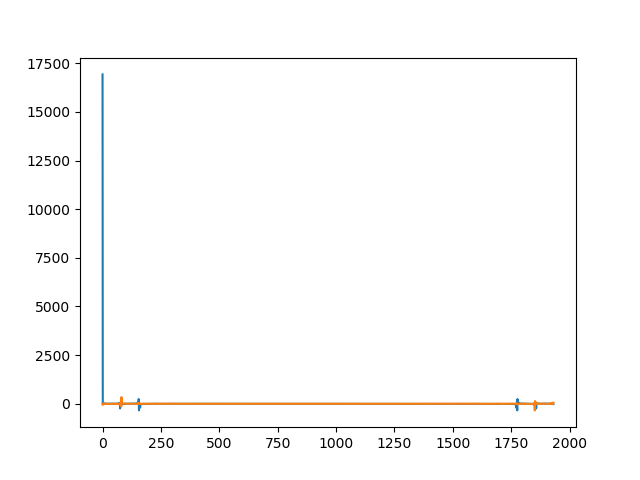

In [12]:
plt.figure()
plt.plot(np.real(wd_fft))
plt.plot(np.imag(wd_fft))
# Note one big spike, some clusters, lots of near-zero.

In [13]:
# Figure out frequencies for each coefficient - but use the library to make it easy.
N = len(waterdep)
deltat = 1/24  # should match dt above
f = np.fft.fftfreq(N, deltat)

<IPython.core.display.Javascript object>


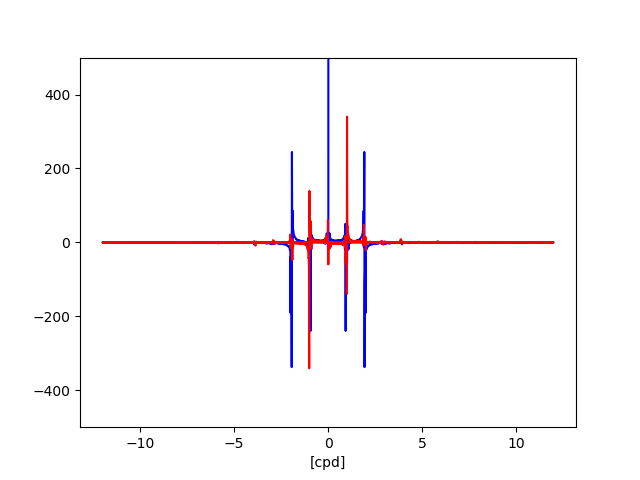

Text(0.5,0,'[cpd]')

In [14]:
plt.figure()
plt.plot(f, np.real(wd_fft), 'b-')
plt.plot(f, np.imag(wd_fft), 'r-')
plt.ylim([-500, 500])
plt.xlabel('[cpd]')

Central blue spike is the mean of the series.  Clusters are around 1/day and 2/day. Cos mostly 2/day, symmetrical
about zero.  Sin bigger at 1/day, not symmetrical, but are if sign is changed (antisymmetric in the time domain).
Both imply redundant information.  Why?  Complex inputs would give asymmetric values (2d data).

Next compute a **power spectrum**.
It relates the amplitudes of the waves to the variance (**power**) of the time series.

In [15]:
S = (2/N)*deltat*np.abs(wd_fft)**2

<IPython.core.display.Javascript object>


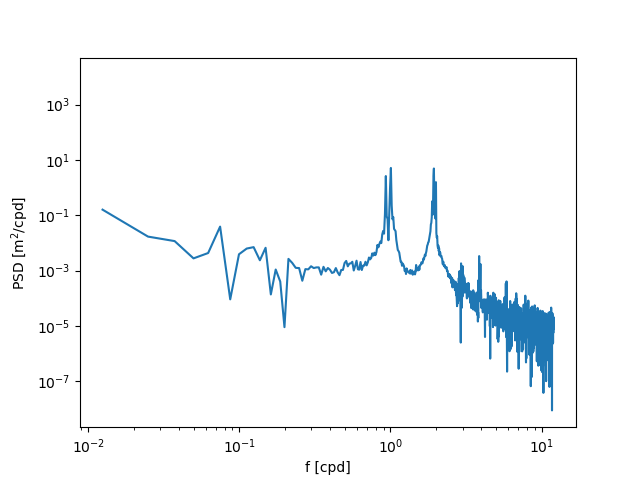

Text(0,0.5,'PSD [m$^2$/cpd]')

In [16]:
plt.figure()
plt.loglog()
plt.plot(f[0:round(N/2)], S[0:round(N/2)])
plt.xlabel('f [cpd]')
plt.ylabel('PSD [m$^2$/cpd]')  #Power spectral density


Double peak at 1/day, another at 2/day, others later (higher freq).
Y axis represents variance contributed.  Units - area under curve is meters squared.

Energy at left - weather around 10 days.  

<IPython.core.display.Javascript object>


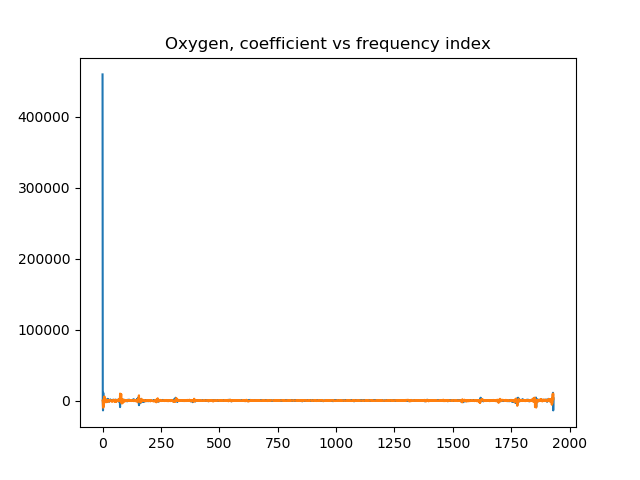

Text(0.5,1,'Oxygen, coefficient vs frequency index')

In [17]:
# A new variable - using Oxygen.
# Fast Fourier transform of oxygen
ox_fft = np.fft.fft(oxygen)
np.shape(ox_fft)  # Shape matches number of observations
plt.figure()
plt.plot(np.real(ox_fft))
plt.plot(np.imag(ox_fft))
plt.title('Oxygen, coefficient vs frequency index')


<IPython.core.display.Javascript object>


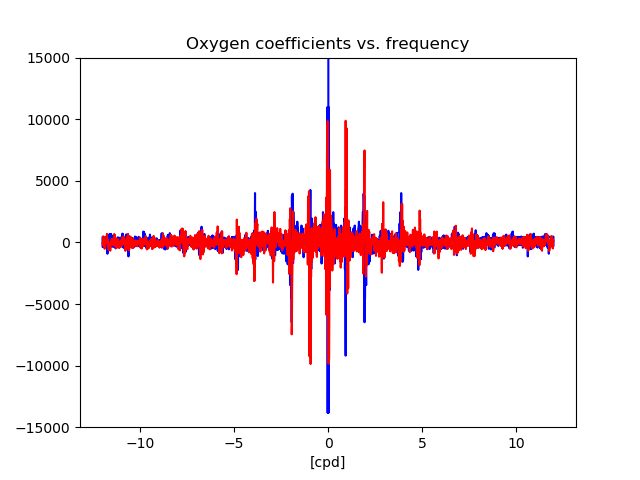

Text(0.5,1,'Oxygen coefficients vs. frequency')

In [18]:
plt.figure()
plt.plot(f, np.real(ox_fft), 'b-')
plt.plot(f, np.imag(ox_fft), 'r-')
plt.ylim([-15000, 15000])
plt.xlabel('[cpd]')
plt.title('Oxygen coefficients vs. frequency')

<IPython.core.display.Javascript object>


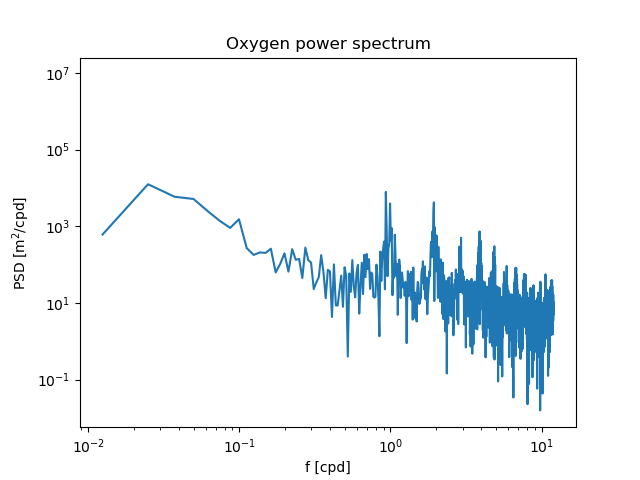

Text(0.5,1,'Oxygen power spectrum')

In [19]:
S_ox = (2/N)*deltat*np.abs(ox_fft)**2
plt.figure()
plt.loglog()
plt.plot(f[0:round(N/2)], S_ox[0:round(N/2)])
plt.xlabel('f [cpd]')
plt.ylabel('PSD [m$^2$/cpd]')  #Power spectral density
plt.title('Oxygen power spectrum')

In [20]:
# Now with scipy signal processing
# periodogram
from scipy.signal import periodogram

fp, Sp = periodogram(waterdep, fs=1/dt) # 24 cycles per day

<IPython.core.display.Javascript object>


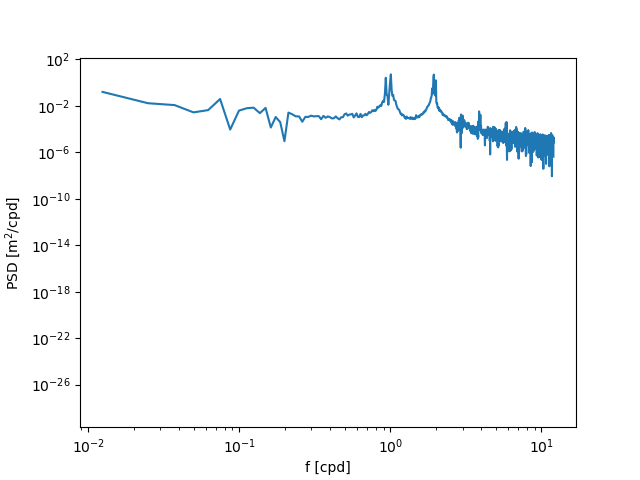

Text(0,0.5,'PSD [m$^2$/cpd]')

In [21]:
plt.figure()
plt.loglog()
plt.plot(fp, Sp)
plt.xlabel('f [cpd]')
plt.ylabel('PSD [m$^2$/cpd]')  #Power spectral density
# plt.([10^-6, 10^])

In [22]:
# repeat and then add refinements
from scipy.signal import periodogram
fp, Sp = periodogram(waterdep, fs=24.)  # fs is sampling freq.

<IPython.core.display.Javascript object>


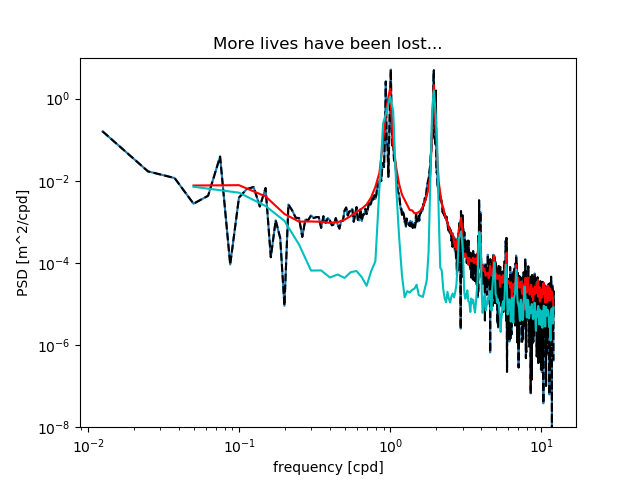

Text(0.5,1,'More lives have been lost...')

In [23]:
plt.figure()
plt.loglog(fp, Sp)
plt.ylim([1e-8, 1e1])
plt.xlabel('frequency [cpd]')
plt.ylabel('PSD [m^2/cpd]')
plt.title('More lives have been lost...')

In [24]:
from scipy.signal import welch

N = len(waterdep)
print(N)

1932


In [25]:
# Recreate with no bells or whistles, but using Welch
# boxcar is just rectangular -> equal weights
f2, S2 = welch(waterdep, fs=24., nperseg=N, window='boxcar')
plt.loglog(f2, S2, 'k--')  # raw periodogram.  plot on old figure - looks the same

f3, S3 = welch(waterdep, fs=24., nperseg=N/4, window='boxcar')
plt.loglog(f3, S3, 'r-')  # with segments, smoother, but looses a double peak at about 1.

f4, S4 = welch(waterdep, fs=24., nperseg=N/4, window='hanning', detrend='linear')
plt.loglog(f4, S4, 'c-')  # with segments, weighting reduces energy leakage at wraparound ends. Minor peaks more distinct.


<IPython.core.display.Javascript object>


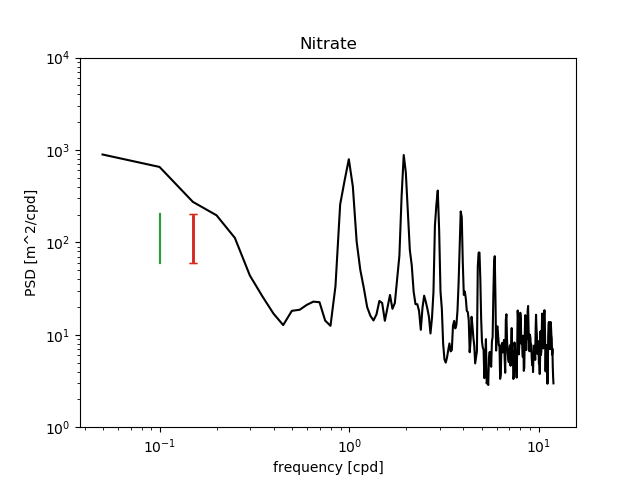

(1.0, 10000.0)

In [92]:
# Exercise: new variable, will include confidence intervals and more.
nitrate = data[:, 2]
plt.figure()
fN, SN = welch(nitrate, fs=24., nperseg=N/4, window='hanning', detrend='linear')
plt.xlabel('frequency [cpd]')
plt.ylabel('PSD [m^2/cpd]')
plt.title('Nitrate')
fraw, Sraw = welch(nitrate, fs=24., nperseg=N, window='boxcar')
#plt.loglog(fraw, Sraw, 'k')
plt.loglog(fN, SN, 'k')  
plt.ylim([1e0, 1e4])



In [94]:
from scipy import stats
# DOF for hanning, 8/3 of N/M
M = N/4/2
DOF = 8/3*N/M
print("Effective degrees of freedom:", DOF)

# Confidence interval width is Sobserved(f)*[nu/chisq]
conf = 0.95
chisq1 = stats.chi2.ppf((1-conf)/2, DOF)
chisq2 = stats.chi2.ppf(conf + (1-conf)/2, DOF)
print('Chisq range:', chisq1, chisq2)

# Plot based on PSD of 100 (should scale on log-log plot)
low = 100*DOF/chisq1
high = 100*DOF/chisq2
print('Error bar high/low:', low, high)

plt.plot([0.1, 0.1], [low, high])

# Not correct as shown - need to allow for log scale?
y_err = np.array([100-low, high-100])
y_err = np.atleast_2d(y_err)
y_err = np.transpose(y_err)
plt.errorbar(0.15, 100, xerr=None, yerr=y_err, capsize=3, elinewidth=2)


Effective degrees of freedom: 21.333333333333332
Chisq range: 10.5152529712 35.9136206344
Error bar high/low: 202.879886882 59.4017895064


<Container object of 3 artists>

The figure shows peaks at 1 day and the next 5 harmonics.  The first two peaks correspond to daily and diurnal tides, while the others are less obvious.  This plot is better than a raw periodogram because it has much less noise, allowing the peaks to stand out more clearly.

In [ ]:
# Repeat with sub-sampled data
nitrate = data[:, 2]
plt.figure()
fN, SN = welch(nitrate, fs=24., nperseg=N/4, window='hanning', detrend='linear')
plt.xlabel('frequency [cpd]')
plt.ylabel('PSD [m^2/cpd]')
plt.title('Nitrate')
fraw, Sraw = welch(nitrate, fs=24., nperseg=N, window='boxcar')
#plt.loglog(fraw, Sraw, 'k')
plt.loglog(fN, SN, 'k')  
plt.ylim([1e0, 1e4])